# Assignment 2 : Language Modeling & Evaluation 

**Student names**: _Your_names_here_ <br>
**Group number**: _Your_group_here_ <br>
**Date**: _Submission Date_

## Important notes
Please read and follow these rules. Submissions that do not fulfill them may be returned.
1. You may work in groups of maximum 2 students.
2. Submit in **.ipynb** format only.
3. The assignment must be typed. Handwritten answers are not accepted.

**Due date**: 28.09.2025 23:59

### What you will do
- Build a **unigram document language model** with a **document-term matrix**.
- Rank documents for queries using **Jelinek-Mercer smoothing**.
- Evaluate the run using **Cranfield queries and qrels** (P@k, MAP, MRR).
- (Optional) Try **Dirichlet** and compare briefly.


---
## Dataset

Make sure the Cranfield files are placed next to the notebook:
- `cran.all.1400` — document collection (1400 docs)
- `cran.qry` — queries
- `cranqrel` — relevance judgments (qrels)

> Only the **document parsing** for cran.all.1400 code is provided below. You will implement the rest in the TODO cells.


### Load and parse documents (provided)

Run the cell to parse the Cranfield documents. Update the path so it points to your `cran.all.1400` file.


In [15]:
# TODO: Read 'cran.all.1400' and parse the documents into a suitable data structure

CRAN_PATH = r"cran.all.1400"  # <-- change this!

def parse_cranfield(path):
    docs = {}
    current_id = None
    current_field = None
    buffers = {"T": [], "A": [], "B": [], "W": []}
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.rstrip("\n")
            if line.startswith(".I "):
                if current_id is not None:
                    docs[current_id] = {
                        "id": current_id,
                        "title": " ".join(buffers["T"]).strip(),
                        "abstract": " ".join(buffers["W"]).strip()
                    }
                current_id = int(line.split()[1])
                buffers = {k: [] for k in buffers}
                current_field = None
            elif line.startswith("."):
                tag = line[1:].strip()
                current_field = tag if tag in buffers else None
            else:
                if current_field is not None:
                    buffers[current_field].append(line)
    if current_id is not None:
        docs[current_id] = {
            "id": current_id,
            "title": " ".join(buffers["T"]).strip(),
            "abstract": " ".join(buffers["W"]).strip()
        }
    print(f"Parsed {len(docs)} documents.")
    return docs

docs = parse_cranfield(CRAN_PATH)
print(list(docs.items())[:1])  # peek at the first parsed doc


Parsed 1400 documents.
[(1, {'id': 1, 'title': 'experimental investigation of the aerodynamics of a wing in a slipstream .', 'abstract': 'experimental investigation of the aerodynamics of a wing in a slipstream .   an experimental study of a wing in a propeller slipstream was made in order to determine the spanwise distribution of the lift increase due to slipstream at different angles of attack of the wing and at different free stream to slipstream velocity ratios .  the results were intended in part as an evaluation basis for different theoretical treatments of this problem .   the comparative span loading curves, together with supporting evidence, showed that a substantial part of the lift increment produced by the slipstream was due to a /destalling/ or boundary-layer-control effect .  the integrated remaining lift increment, after subtracting this destalling lift, was found to agree well with a potential flow theory .   an empirical evaluation of the destalling effects was made fo

In [16]:
#All used imports:
import numpy as np
from scipy.sparse import csr_matrix
import string

## 2.1 Language Modeling

You will create a **unigram language model** per document, using a **document-term matrix**, and score queries with **Jelinek-Mercer smoothing**.


### 2.1.1 Preprocessing

Implement a simple tokenizer/normalizer (e.g., lowercasing, punctuation removal and stopword removal) and apply it to each document

- Return a list of tokens for each document.


In [17]:
# TODO: Implement preprocessing and apply to all documents

STOPWORDS = set("""a about above after again against all am an and any are aren't as at be because been
before being below between both but by can't cannot could couldn't did didn't do does doesn't doing don't down
during each few for from further had hadn't has hasn't have haven't having he he'd he'll he's her here here's hers
herself him himself his how how's i i'd i'll i'm i've if in into is isn't it it's its itself let's me more most
mustn't my myself no nor not of off on once only or other ought our ours ourselves out over own same shan't she
she'd she'll she's should shouldn't so some such than that that's the their theirs them themselves then there there's
these they they'd they'll they're they've this those through to too under until up very was wasn't we we'd we'll we're
we've were weren't what what's when when's where where's which while who who's whom why why's with won't would wouldn't
you you'd you'll you're you've your yours yourself yourselves""".split())

# Your code here

def preprocess_documents(docs):
    result = []
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    
    for doc in docs.values():
        # Combine title and abstract
        text = f"{doc['title']} {doc['abstract']}".lower()
        
        # Remove punctuation
        text = text.translate(translator)
        
        # Tokenize
        tokens = text.split()
        
        # Remove stopwords + empty tokens
        filtered_tokens = [t for t in tokens if t not in STOPWORDS and t.strip()]
        
        result.append(filtered_tokens)
    
    return result


tokenized_documents = preprocess_documents(docs)  # Returns list of token lists

### 2.1.2 Build the matrix

Construct:
- A vocabulary `term -> column_index`
- A (sparse) **document–term count matrix**
- Document lengths `|d|` and collection (all documents) totals

> Tip: You may use dictionaries or `scipy.sparse` for efficiency.


In [18]:
# TODO: Build vocabulary, doc-term counts (sparse), document lengths, and collection totals
# Your code here
import numpy as np
from scipy.sparse import csr_matrix

def build_document_term_matrix(tokenized_documents):
    """
    Builds:
      - Vocabulary (term -> column_index)
      - Sparse document-term count matrix
      - Document lengths |d|
      - Collection total (sum of lengths)
    """
    
    # Build vocabulary
    vocab = {}
    current_index = 0
    for doc_tokens in tokenized_documents:
        for term in doc_tokens:
            if term not in vocab:
                vocab[term] = current_index
                current_index += 1
    
    # Prepare lists for sparse matrix construction
    rows, cols, data = [], [], []
    
    for doc_id, doc_tokens in enumerate(tokenized_documents):
        term_counts = {}
        for term in doc_tokens:
            col_idx = vocab[term]
            term_counts[col_idx] = term_counts.get(col_idx, 0) + 1
        
        # Fill row, col, data
        for col_idx, count in term_counts.items():
            rows.append(doc_id)
            cols.append(col_idx)
            data.append(count)
    
    # Sparse document-term matrix
    doc_term_matrix = csr_matrix((data, (rows, cols)), 
                                 shape=(len(tokenized_documents), len(vocab)),
                                 dtype=np.int32)
    
    # Document lengths
    doc_lengths = np.array(doc_term_matrix.sum(axis=1)).ravel()
    
    # Collection total
    collection_total = doc_lengths.sum()
    
    return vocab, doc_term_matrix, doc_lengths, collection_total


# Example usage
vocab, doc_term_matrix, doc_lengths, collection_total = build_document_term_matrix(tokenized_documents)

print(f"Vocabulary size: {len(vocab)}")
print(f"Matrix shape: {doc_term_matrix.shape}")
print(f"Document lengths: {doc_lengths}")
print(f"Collection total: {collection_total}")



Vocabulary size: 7361
Matrix shape: (1400, 7361)
Document lengths: [ 84 130  25 ... 121  56  73]
Collection total: 145134


### 2.1.3 Rank with **Jelinek-Mercer smoothing**

Implement query likelihood scoring with Jelinek-Mercer smoothing:

$\hat{P}(t \mid M_d) = \lambda \hat{P}_{\text{mle}}(t \mid M_d) + (1 - \lambda)\hat{P}_{\text{mle}}(t \mid M_c), \ \lambda = 0.5$



In [19]:
""" TODO: Create a function for implementing query likelihood scoring with Jelinek Mercer smoothing (λ=0.5), 
using the formula above."""

dLAMBDA = 0.5  # Jelinek-Mercer smoothing parameter

def jelinek_smoothing(query, vocab=vocab, 
                      doc_term_matrix=doc_term_matrix, 
                      doc_lengths=doc_lengths, 
                      collection_total=collection_total):
    
    query_tokens = query.lower().split()
    scores = np.zeros(doc_term_matrix.shape[0])  # one score per doc
    
    for term in query_tokens:
        if term not in vocab:
            continue  # skip OOV terms
        col_idx = vocab[term]
        
        # f_{t,d}: term frequency in each doc
        term_freqs = doc_term_matrix[:, col_idx].toarray().ravel()
        
        # P_mle(t|Md) = f_{t,d} / |d|
        p_td = np.divide(term_freqs, doc_lengths, 
                         out=np.zeros_like(term_freqs, dtype=float), 
                         where=doc_lengths > 0)
        
        # f_{t,C}: term frequency in collection
        f_tc = term_freqs.sum()
        
        # P_mle(t|Mc) = f_{t,C} / |C|
        p_tc = f_tc / collection_total if collection_total > 0 else 0.0
        
        # Jelinek-Mercer smoothed probability
        smoothed = LAMBDA * p_td + (1 - LAMBDA) * p_tc
        
        # Add log probs (avoid log(0) by masking)
        scores += np.log(smoothed + 1e-12)  
    
    # Rank documents by descending score
    ranked_docs = np.argsort(-scores)
    return ranked_docs.tolist()

In [20]:
# Do not change this code
queries_assignment2 = [
  "gas pressure",
  "structural aeroelastic flight high speed aircraft",
  "heat conduction composite slabs",
  "boundary layer control",
  "compressible flow nozzle",
  "combustion chamber injection",
  "laminar turbulent transition",
  "fatigue crack growth",
  "wing tip vortices",
  "propulsion efficiency"
]

In [21]:
# Run Jelinek-Mercer smoothing on queries in batch (print top-10 results for each), using the function you created
def run_batch_smoothing(queries):
    results = {}
    for i, q in enumerate(queries, 1):
        res = jelinek_smoothing(q)
        results[f"Q{i}"] = res
    return results

jelinek_results = run_batch_smoothing(queries_assignment2)

for qid, res in jelinek_results.items():
    print(qid, "=>", res[:10])


Q1 => [168, 182, 1002, 1311, 1314, 1142, 1273, 974, 1318, 1138]
Q2 => [11, 140, 745, 50, 874, 1168, 1169, 13, 883, 1262]
Q3 => [398, 4, 143, 484, 180, 541, 581, 1072, 118, 90]
Q4 => [264, 1204, 1287, 415, 2, 973, 3, 341, 932, 1348]
Q5 => [117, 388, 774, 964, 216, 325, 940, 983, 1186, 538]
Q6 => [1142, 1240, 1253, 1179, 594, 634, 1194, 1268, 695, 690]
Q7 => [417, 336, 557, 95, 525, 206, 1263, 1286, 958, 314]
Q8 => [1195, 767, 883, 725, 882, 557, 329, 864, 908, 834]
Q9 => [674, 432, 245, 287, 433, 288, 221, 1341, 901, 792]
Q10 => [967, 1327, 1379, 1091, 591, 577, 181, 1150, 723, 1269]


#### Dirichlet

If you have time, also implement Dirichlet smoothing and briefly compare the top-10 lists for the first query in the queries_assignment2 list


In [22]:
# TODO (Optional): Implement Dirichlet scoring and compare with Jelinek-Mercer
# Your code here


## 2.2 Evaluation (Cranfield queries + qrels)

Evaluate your retrieval system using **Cranfield**:
- Parse **queries** from `cran.qry`
- Parse **relevance judgments** from `cranqrel`
- Compute **P@k (k=5,10)**, **MAP (Mean Average Precision)**, and **MRR (Mean Reciprocal Rank)** over all queries


### 2.2.1 Parse `cran.qry` and `cranqrel`

- Create `queries[qid] = "text"` by parsing `cran.qry`
- Create `qrels[qid] = set(relevant_doc_ids)` by parsing `cranqrel`


In [23]:
# TODO: Parse cran.qry and cranqrel into convenient data structures
# Your code here
def parse_cran_queries(path):
    queries = {}
    current_id = None
    buffer = []
    
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.rstrip("\n")
            if line.startswith(".I "):
                # save previous query if any
                if current_id is not None:
                    queries[current_id] = " ".join(buffer).strip()
                current_id = int(line.split()[1])
                buffer = []
            elif line.startswith(".W"):
                continue  # marker line, ignore
            else:
                buffer.append(line)
    
    # save the last query
    if current_id is not None:
        queries[current_id] = " ".join(buffer).strip()
    
    print(f"Parsed {len(queries)} queries.")
    return queries


def parse_qrels(path):
    qrels = {}
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            parts = line.split()
            if len(parts) < 2:
                continue
            qid = int(parts[0])
            doc_id = int(parts[1])
            if qid not in qrels:
                qrels[qid] = set()
            qrels[qid].add(doc_id)
    
    print(f"Parsed relevance judgments for {len(qrels)} queries.")
    return qrels


# Example usage
queries = parse_cran_queries("cran.qry")
qrels = parse_qrels("cranqrel")

print("First query:", list(queries.items())[:1])
print("First qrels entry:", list(qrels.items())[:1])


Parsed 225 queries.
Parsed relevance judgments for 225 queries.
First query: [(1, 'what similarity laws must be obeyed when constructing aeroelastic models of heated high speed aircraft .')]
First qrels entry: [(1, {12, 13, 14, 15, 142, 29, 30, 31, 37, 51, 52, 184, 185, 57, 56, 66, 195, 462, 858, 859, 95, 102, 486, 875, 876, 879, 880, 497, 378})]


### 2.2.2 Implement metrics: P@k, MAP, MRR

Write functions to compute:
- Precision@k (for **k=5** and **k=10**)
- Mean Average Precision (MAP)
- Mean Reciprocal Rank (MRR)


In [24]:
# TODO: Implement P@k (k=5,10), MAP, and MRR
# Your code here
def precision_at_k(retrieved, relevant, k):
    """Compute Precision@k for a single query."""
    retrieved_k = retrieved[:k]
    rel_count = sum(1 for doc_id in retrieved_k if doc_id in relevant)
    return rel_count / k


def average_precision(retrieved, relevant):
    """Compute Average Precision (AP) for a single query."""
    if not relevant:
        return 0.0
    precisions = []
    rel_found = 0
    for rank, doc_id in enumerate(retrieved, start=1):
        if doc_id in relevant:
            rel_found += 1
            precisions.append(rel_found / rank)
    return sum(precisions) / len(relevant)


def reciprocal_rank(retrieved, relevant):
    """Compute Reciprocal Rank (RR) for a single query."""
    for rank, doc_id in enumerate(retrieved, start=1):
        if doc_id in relevant:
            return 1.0 / rank
    return 0.0


### 2.2.3 Evaluate your run

- For **all queries**, generate rankings with your **Jelinek-Mercer** model
- Report aggregate metrics: P@5, P@10, MAP, MRR


In [25]:
# TODO: Run retrieval for all queries and compute P@5, P@10, MAP, and MRR
# Your code here
# Generate rankings for all Cranfield queries using Jelinek-Mercer
results = {}
for qid, query_text in queries.items():
    results[qid] = jelinek_smoothing(query_text)  # from earlier JM function

# Compute aggregate metrics
p5, p10, APs, RRs = [], [], [], []

for qid, retrieved in results.items():
    relevant = qrels.get(qid, set())
    p5.append(precision_at_k(retrieved, relevant, 5))
    p10.append(precision_at_k(retrieved, relevant, 10))
    APs.append(average_precision(retrieved, relevant))
    RRs.append(reciprocal_rank(retrieved, relevant))

print("Evaluation Results")
print(f"P@5 :  {sum(p5)/len(p5):.4f}")
print(f"P@10:  {sum(p10)/len(p10):.4f}")
print(f"MAP :  {sum(APs)/len(APs):.4f}")
print(f"MRR :  {sum(RRs)/len(RRs):.4f}")



Evaluation Results
P@5 :  0.0053
P@10:  0.0067
MAP :  0.0081
MRR :  0.0228



### 2.2.4 Interpolated precision–recall curves (11‑point)

- For **all queries**, if you don’t have query IDs, assign sequential IDs: `Q1, Q2, ..., Qm` in the order they appear.
- Using your **rankings from task 2.2.3** and the **relevance judgments (`cranqrel`)**, compute **precision** and **recall** at each rank for each query.
- For the 11 standard recall levels `R = {0.0, 0.1, ..., 1.0}`, compute the **interpolated precision** at level `r` as the **maximum precision** observed at any point with recall ≥ `r`.
- **Report/plot** the **11‑point interpolated precision–recall curve** across queries (and optionally a few per‑query curves).

In [26]:

# TODO: Compute the 11-point interpolated precision–recall for each query

# Your code here
def precision_recall_curve(retrieved, relevant):
    """Compute precision-recall pairs for a single query."""
    precisions, recalls = [], []
    rel_found = 0
    total_relevant = len(relevant)
    if total_relevant == 0:
        return [], []  # skip queries with no judgments
    
    for rank, doc_id in enumerate(retrieved, start=1):
        if doc_id in relevant:
            rel_found += 1
        precision = rel_found / rank
        recall = rel_found / total_relevant
        precisions.append(precision)
        recalls.append(recall)
    
    return precisions, recalls


def interpolated_precision(precisions, recalls, recall_levels=np.linspace(0.0, 1.0, 11)):
    """Compute 11-point interpolated precision curve."""
    interp = []
    for r in recall_levels:
        # max precision observed at any recall >= r
        p = max([p for p, rec in zip(precisions, recalls) if rec >= r], default=0.0)
        interp.append(p)
    return interp

# Assign sequential IDs if not already present
all_qids = list(results.keys())
if isinstance(all_qids[0], int):  # cran.qry already has IDs
    qid_labels = all_qids
else:
    qid_labels = [f"Q{i+1}" for i in range(len(all_qids))]

recall_levels = np.linspace(0.0, 1.0, 11)
all_curves = []

for qid in all_qids:
    retrieved = results[qid]
    relevant = qrels.get(qid, set())
    precisions, recalls = precision_recall_curve(retrieved, relevant)
    if recalls:  # only if query has judgments
        interp = interpolated_precision(precisions, recalls, recall_levels)
        all_curves.append(interp)

# Average across queries
mean_curve = np.mean(all_curves, axis=0)



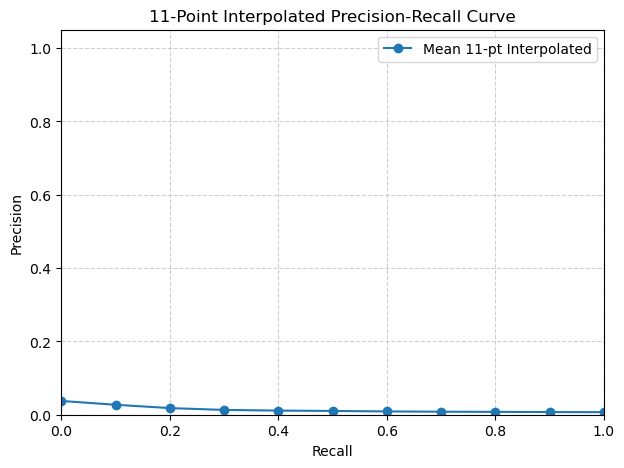

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(recall_levels, mean_curve, marker="o", label="Mean 11-pt Interpolated")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("11-Point Interpolated Precision-Recall Curve")
plt.ylim(0, 1.05)
plt.xlim(0, 1.0)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


In [28]:
qid = 1
print("Query:", queries[qid])
print("Top 10 retrieved:", results[qid][:10])
print("Relevant docs:", list(qrels[qid])[:10])


Query: what similarity laws must be obeyed when constructing aeroelastic models of heated high speed aircraft .
Top 10 retrieved: [485, 183, 12, 11, 1267, 877, 50, 874, 140, 745]
Relevant docs: [12, 13, 14, 15, 142, 29, 30, 31, 37, 51]


In [29]:
def pr_at_ranks(ranked_docs, relevant_docs):
    precisions, recalls = [], []
    retrieved_rels = 0
    for i, d in enumerate(ranked_docs, 1):
        if d in relevant_docs:
            retrieved_rels += 1
        precision = retrieved_rels / i
        recall = retrieved_rels / len(relevant_docs)
        precisions.append(precision)
        recalls.append(recall)
    return precisions, recalls

qid = 1
precisions, recalls = pr_at_ranks(results[qid], qrels[qid])
for i, (p, r) in enumerate(zip(precisions[:15], recalls[:15]), 1):
    print(f"Rank {i}: Precision={p:.3f}, Recall={r:.3f}")


Rank 1: Precision=0.000, Recall=0.000
Rank 2: Precision=0.000, Recall=0.000
Rank 3: Precision=0.333, Recall=0.034
Rank 4: Precision=0.250, Recall=0.034
Rank 5: Precision=0.200, Recall=0.034
Rank 6: Precision=0.167, Recall=0.034
Rank 7: Precision=0.143, Recall=0.034
Rank 8: Precision=0.125, Recall=0.034
Rank 9: Precision=0.111, Recall=0.034
Rank 10: Precision=0.100, Recall=0.034
Rank 11: Precision=0.091, Recall=0.034
Rank 12: Precision=0.083, Recall=0.034
Rank 13: Precision=0.077, Recall=0.034
Rank 14: Precision=0.071, Recall=0.034
Rank 15: Precision=0.133, Recall=0.069
